<a href="https://colab.research.google.com/github/DyanielCX/DLI-Assm/blob/main/GroupZ_Model_Compilation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Import All Dependencies & Libraries

In [36]:
%pip install scikit-optimize

In [37]:
import time, os, json, random
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path

# SKLearn Module
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Integer
from scipy.stats import mode

# Matploylib Module
from matplotlib import colormaps
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, SimpleRNN, Dense,
    Conv1D, GlobalMaxPooling1D, Dropout
)

# Tensor Flow Module
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping





# Data Loading

In [38]:
# Importing the dataset from GitHub
github_csv_url = 'https://raw.githubusercontent.com/DyanielCX/DLI-Assm/refs/heads/main/dataset_B_05_2020_1.csv'
raw_dataset = pd.read_csv(github_csv_url)

# Data Pre-pocessing

In [39]:
''' Dataset for Deep Learning '''
# Copy the raw dataset with only 'url' and 'status' columns
DL_dataset = raw_dataset[['url', 'status']].copy()
DL_dataset['url'] = DL_dataset['url'].str.lower()

# Encode status column
label_encoder = LabelEncoder()
DL_dataset['status'] = label_encoder.fit_transform(DL_dataset['status'])

# Tokenize URLs for RNN
urls = DL_dataset['url'].astype(str).values
labels = DL_dataset['status'].values

tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(urls)
sequences = tokenizer.texts_to_sequences(urls)
max_len = 200
X_padded = pad_sequences(sequences, maxlen=max_len)
vocab_size = len(tokenizer.word_index) + 1

# Keep text + label for DL
df = raw_dataset[["url", "status"]].dropna().copy()
df["url"] = df["url"].astype(str).str.lower()
y = df["status"].astype(int).values
texts = df["url"].tolist()

''' Dataset for Machine Learning '''
# Copy the raw dataset
ML_dataset = raw_dataset.copy()

# Drop the URL columns (ML only need numeric vectors data)
if 'url' in ML_dataset.columns:
    ML_dataset = ML_dataset.drop(columns=['url'])

# Model Used





*   **Dyaniel** -> Recurrent Nueral Network (RNN) + Cluster Labeling K-Means (CL K-Means)
*   **Ho Feng Sheng** -> Convolutional Nueral Network (CNN) + Support Vector Machine (SVM)
*   **Lee Zhen Yong** -> Random Forest
*   **Lee Guo Xi** -> Long Short-Term Memory (LSTM)

# Model Training

## Dyaniel Model Training (RNN + CL K-Means)

### 1. RNN Deep Learning Model

In [40]:
# Set start time for recording the model training time
dy_train_start_time = time.time()

# Set a random seed for reproducibility
np.random.seed(42)

# Train/test split
dy_X_train, dy_X_test, dy_y_train, dy_y_test = train_test_split(
    X_padded, labels, test_size=0.2, random_state=42, stratify=labels
)

# Build RNN model
input_layer = Input(shape=(max_len,))
embedding = Embedding(input_dim=vocab_size, output_dim=32)(input_layer)
rnn_output = SimpleRNN(64, return_sequences=False, name="rnn_features")(embedding)
output = Dense(1, activation='sigmoid')(rnn_output)

RNN_model = Model(inputs=input_layer, outputs=output)
RNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train RNN with custom settings
RNN_model.fit(
    dy_X_train,
    dy_y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 32s 125ms/step - accuracy: 0.6454 - loss: 0.6079 - val_accuracy: 0.8092 - val_loss: 0.4476
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.8057 - loss: 0.4281 - val_accuracy: 0.8393 - val_loss: 0.3867
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.8227 - loss: 0.3983 - val_accuracy: 0.8496 - val_loss: 0.3550
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.8361 - loss: 0.3680 - val_accuracy: 0.8453 - val_loss: 0.3474
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.8515 - loss: 0.3451 - val_accuracy: 0.8458 - val_loss: 0.3438
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.8574 - loss: 0.3326 - val_accuracy: 0.8535 - val_loss: 0.3401
Epoch 7/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.8704 - loss: 0.3131 - val_accuracy: 0.8540 - val_loss: 0.3316
Epoch 8/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.8739 - loss: 0.2978 -

### 2. Extract RNN Features & Merge with ML_Dataset

In [41]:
# Create a new model that outputs the RNN layer
feature_extractor = Model(
    inputs=RNN_model.input,
    outputs=RNN_model.get_layer("rnn_features").output  # 'rnn_features' is the layer name
)

try:
    # Apply it on the full padded URL input
    rnn_features = feature_extractor.predict(X_padded)

    # Convert to DataFrame
    rnn_feature_df = pd.DataFrame(
        rnn_features,
        columns=[f"rnn_feat_{i}" for i in range(rnn_features.shape[1])]
    )
except Exception as e:
    print(f"❌ An error occurred during RNN feature extraction: {e}")
finally:
    print("✅ RNN feature extraction process done.")


try:
  # Drop "status" column and reset index
  ml_only = ML_dataset.drop(columns=['status']).reset_index(drop=True)

  # Standardize ML features
  scaler = StandardScaler()
  ml_scaled = scaler.fit_transform(ml_only)
  ml_scaled_df = pd.DataFrame(ml_scaled, columns=ml_only.columns)

  # Combine with RNN features
  combined_features = pd.concat([ml_scaled_df, rnn_feature_df], axis=1)

  # Reattach "status" column
  ML_combined_dataset = combined_features.copy()
  ML_combined_dataset['status'] = ML_dataset['status'].reset_index(drop=True)

except Exception as e:
    print(f"❌ An error occurred during ML dataset merging: {e}")
finally:
    print("✅ ML dataset merging done.")
    print("Final merged and scaled dataset shape:", ML_dataset.shape)

358/358 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
✅ RNN feature extraction process done.
✅ ML dataset merging done.
Final merged and scaled dataset shape: (11430, 88)


### 3. CL_K-Means Machine Learning

In [42]:
X = ML_combined_dataset.drop(columns=['status'])
y = ML_combined_dataset['status']

# Find the Best k using BO-TPE (Bayesian Optimization)
search_space = {'n_clusters': Integer(2, 10)}
opt_kmeans = BayesSearchCV(KMeans(random_state=42), search_space, n_iter=10, cv=3, scoring='accuracy', verbose=0)
opt_kmeans.fit(X, y)
best_k = opt_kmeans.best_params_['n_clusters']
print(f"✅ Best k found by BO-TPE: {best_k}")

# Train CL-KMeans
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(X)

# Map clusters to true labels using majority voting
mapped_labels = np.zeros_like(clusters)
for i in range(best_k):
    mask = (clusters == i)
    mapped_labels[mask] = mode(y[mask])[0]

# Train Random Forest for Bias Correction
dy2_X_train, dy2_X_test, dy2_y_train, dy2_y_test = train_test_split(X, mapped_labels, test_size=0.2, stratify=y, random_state=42)
bias_corrector = RandomForestClassifier(random_state=42)
bias_corrector.fit(dy2_X_train, dy2_y_train)

# Get the model training time
dy_training_time = time.time() - dy_train_start_time
dy_training_time = round(dy_training_time / 60, 4)

✅ Best k found by BO-TPE: 2


## Ho Feng Sheng Model Training (CNN + SVM)

### 1. Train CNN to Learn from URL

In [43]:
# Set start time for recording the model training time
js_train_start_time = time.time()

# Set a random seed for reproducibility
np.random.seed(42)

# CNN architecture
input_layer = Input(shape=(200,))
embedding = Embedding(input_dim=vocab_size, output_dim=128)(input_layer)
conv = Conv1D(filters=256, kernel_size=5, activation='relu')(embedding)
drop = Dropout(0.3)(conv)
pool = GlobalMaxPooling1D(name="cnn_features")(drop)
output_layer = Dense(1, activation='sigmoid')(pool)

# Compile model
CNN_model = Model(inputs=input_layer, outputs=output_layer)
CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Split for DL training only
js_X_train_dl, js_X_test_dl, js_y_train_dl, js_y_test_dl = train_test_split(X_padded, y, test_size=0.2, stratify=y, random_state=42)

# Train CNN model
CNN_model.fit(js_X_train_dl, js_y_train_dl, epochs=5, batch_size=128, validation_split=0.1, verbose=1)



Epoch 1/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 39s 582ms/step - accuracy: 0.7091 - loss: 0.5762 - val_accuracy: 0.8153 - val_loss: 0.3976
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 575ms/step - accuracy: 0.8394 - loss: 0.3623 - val_accuracy: 0.8710 - val_loss: 0.3132
Epoch 3/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 590ms/step - accuracy: 0.8845 - loss: 0.2807 - val_accuracy: 0.9016 - val_loss: 0.2682
Epoch 4/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 577ms/step - accuracy: 0.9063 - loss: 0.2370 - val_accuracy: 0.9038 - val_loss: 0.2440
Epoch 5/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 575ms/step - accuracy: 0.9207 - loss: 0.2033 - val_accuracy: 0.9148 - val_loss: 0.2250


### 2. Extract CNN Features & Merge with ML Features

In [44]:
# Create a feature extractor model that outputs from 'cnn_features' layer
feature_extractor = Model(inputs=CNN_model.input,
                          outputs=CNN_model.get_layer("cnn_features").output)

# Apply on all padded URL sequences to extract CNN features
cnn_features = feature_extractor.predict(X_padded)

# Standardize ML numerical features
ml_features = raw_dataset.drop(columns=['url', 'status'])
scaler = StandardScaler()
ml_scaled = scaler.fit_transform(ml_features)

# Combine CNN features with numeric ML features
X_combined = np.hstack([cnn_features, ml_scaled])

358/358 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step


### 3. Train Final SVM Classifier

In [45]:
js2_X_train, js2_X_test, js2_y_train, js2_y_test = train_test_split(X_combined, y, test_size=0.2, stratify=y, random_state=42)

svm_model = LinearSVC(
    loss="squared_hinge", penalty='l2', dual=True, max_iter=100000,
    tol=1e-3, class_weight='balanced', C=1.0, random_state=42
)

svm_model.fit(js2_X_train, js2_y_train)

# Get the model training time
js_training_time = time.time() - js_train_start_time
js_training_time = round(js_training_time / 60, 4)

## Lee Zhen Yong Model Training (Random Forest)

## Lee Guo Xi Model Training (LSTM)

### 1. Character-level tokenization

In [91]:
# Keep punctuation/symbols: set filters="" and char_level=True
tok = Tokenizer(char_level=True, lower=True, filters="")
tok.fit_on_texts(texts)
seqs = tok.texts_to_sequences(texts)
lengths = np.array([len(s) for s in seqs])

# Use 95th percentile as maxlen to avoid over-padding
maxlen = int(np.percentile(lengths, 95))
maxlen = max(maxlen, 64)
X = pad_sequences(seqs, maxlen=maxlen, padding="post", truncating="post")

### 2. Train/Val/Test split

In [92]:
# Set a random seed for reproducibility
# np.random.seed(42)

guoxi_X_train, guoxi_X_test, guoxi_y_train, guoxi_y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    guoxi_X_train, guoxi_y_train, test_size=0.10, random_state=42, stratify=guoxi_y_train
)

vocab_size = len(tok.word_index) + 1
print("Vocab size (chars):", vocab_size)

Vocab size (chars): 74


### 3. Build LSTM model

In [93]:
def build_model(vocab, seq_len, emb_dim=64, lstm_units=64, lr=1e-3):
    inp = layers.Input(shape=(seq_len,), dtype="int32")
    x = layers.Embedding(vocab, emb_dim)(inp)
    x = layers.Bidirectional(layers.LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2))(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inp, out)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_model(vocab_size, maxlen)

es = callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5)


### 4. Train + measure time

In [94]:
t0 = time.perf_counter()
hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=7,
    batch_size=256,
    callbacks=[es, rlr],
    verbose=1
)
t1 = time.perf_counter()
guoxi_training_time = t1 - t0
guoxi_training_time = round(js_training_time / 60, 4)

Epoch 1/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 728ms/step - accuracy: 0.6031 - loss: 0.6637 - val_accuracy: 0.7672 - val_loss: 0.5096 - learning_rate: 0.0010
Epoch 2/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 39s 687ms/step - accuracy: 0.7551 - loss: 0.5300 - val_accuracy: 0.7705 - val_loss: 0.4889 - learning_rate: 0.0010
Epoch 3/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 653ms/step - accuracy: 0.7596 - loss: 0.5082 - val_accuracy: 0.7847 - val_loss: 0.4721 - learning_rate: 0.0010
Epoch 4/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 675ms/step - accuracy: 0.7716 - loss: 0.4856 - val_accuracy: 0.7847 - val_loss: 0.4667 - learning_rate: 0.0010
Epoch 5/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 677ms/step - accuracy: 0.7793 - loss: 0.4845 - val_accuracy: 0.7858 - val_loss: 0.4449 - learning_rate: 0.0010
Epoch 6/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 682ms/step - accuracy: 0.7827 - loss: 0.4686 - val_accuracy: 0.7825 - val_loss: 0.4473 - learning_rate: 0.0010
Epoch 7/7
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 675ms/step - accuracy: 0.7782 - loss: 0.4726 - 

In [95]:
# Prediction time per sample (ms)
t2 = time.perf_counter()
y_proba = model.predict(guoxi_X_test, batch_size=512).ravel()
t3 = time.perf_counter()
pred_time_ms_per_sample = ((t3 - t2) / len(guoxi_X_test)) * 1000.0

guoxi_y_pred = (y_proba >= 0.5).astype(int)

guoxi_acc  = accuracy_score(guoxi_y_test, guoxi_y_pred)
guoxi_prec = precision_score(guoxi_y_test, guoxi_y_pred, zero_division=0)
guoxi_rec  = recall_score(guoxi_y_test, guoxi_y_pred, zero_division=0)
guoxi_f1   = f1_score(guoxi_y_test, guoxi_y_pred, zero_division=0)
guoxi_auc  = roc_auc_score(guoxi_y_test, y_proba)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step


# Model Evaluation Metrics

## Get Model Metrics

In [96]:
''' Get Dyaniel Model Metrics '''
# Calculate Prediction Time
dy_pred_start_time = time.time()
dy_corrected_preds = bias_corrector.predict(dy2_X_test)
dy_prediction_time = time.time() - dy_pred_start_time
dy_prediction_time = round(dy_prediction_time * 1000, 4)

# Calculate Evaluation Metrics
dy_accuracy = accuracy_score(dy2_y_test, dy_corrected_preds)
precision = precision_score(dy2_y_test, dy_corrected_preds, average='weighted')
recall = recall_score(dy2_y_test, dy_corrected_preds, average='weighted')
dy_f1 = f1_score(dy2_y_test, dy_corrected_preds, average='weighted')

''' Get Joseph Model Metrics '''
# Calculate Prediction Time
js_predict_start_time = time.time()
js_corrected_preds = svm_model.predict(js2_X_test)
js_prediction_time = time.time() - js_predict_start_time
js_prediction_time = round(js_prediction_time * 1000, 4)

# Calculate Evaluation Metrics
js_y_scores = svm_model.decision_function(js2_X_test)
js_accuracy = accuracy_score(js2_y_test, js_corrected_preds)
js_precision = precision_score(js2_y_test, js_corrected_preds)
js_recall = recall_score(js2_y_test, js_corrected_preds)
js_f1 = f1_score(js2_y_test, js_corrected_preds)
js_roc_auc = roc_auc_score(js2_y_test, js_y_scores)

''' Get Lee Zhen Yong Model Metrics '''


''' Get Lee Guo Xi Model Metrics '''
# Calculate Prediction Time
t2 = time.perf_counter()
y_proba = model.predict(guoxi_X_test, batch_size=512).ravel()
t3 = time.perf_counter()
pred_time_ms_per_sample = ((t3 - t2) / len(guoxi_X_test))
guoxi_prediction_time = round(pred_time_ms_per_sample * 1000, 4)

# Calculate Evaluation Metrics
js_y_scores = (y_proba >= 0.5).astype(int)
guoxi_accuracy  = accuracy_score(guoxi_y_test, guoxi_y_pred)
guoxi_prec = precision_score(guoxi_y_test, guoxi_y_pred, zero_division=0)
guoxi_precision  = recall_score(guoxi_y_test, guoxi_y_pred, zero_division=0)
guoxi_f1   = f1_score(guoxi_y_test, guoxi_y_pred, zero_division=0)
guoxi_roc_auc  = roc_auc_score(guoxi_y_test, y_proba)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step


## Confusion Matrix

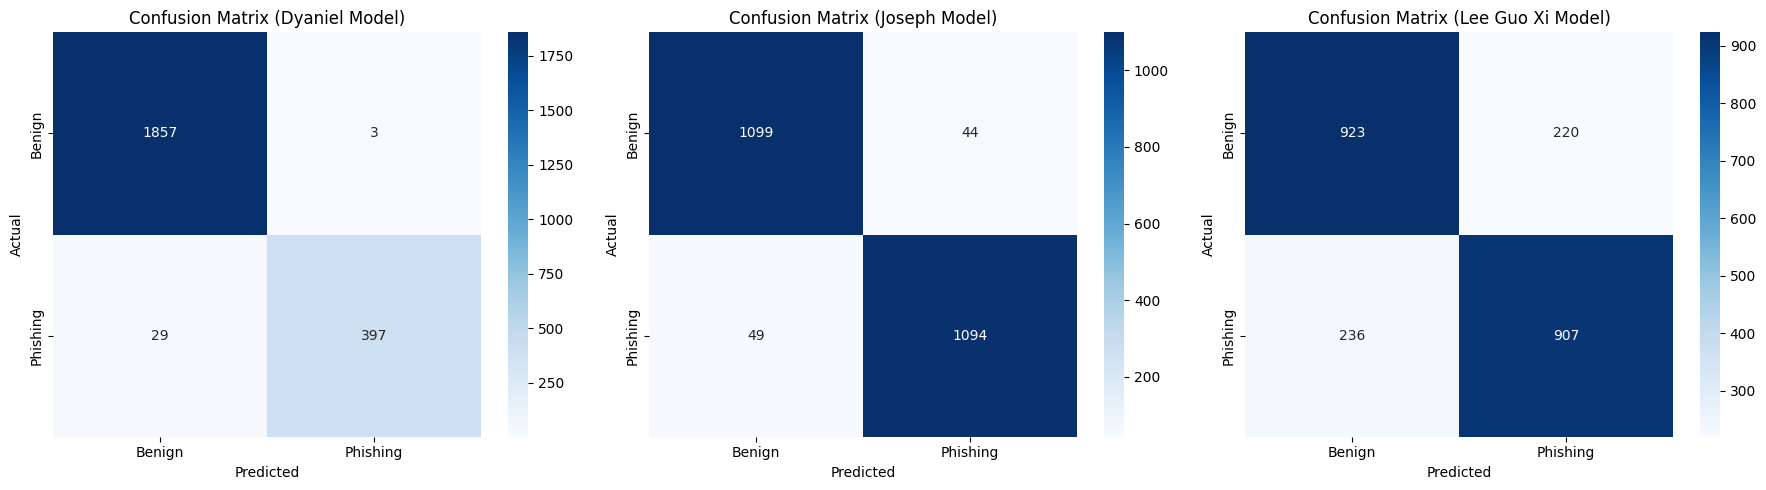

In [104]:
# Combined Confusion Matrix
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Dyaniel Model Confusion Matrix
cm_dy = confusion_matrix(dy2_y_test, dy_corrected_preds)
sns.heatmap(cm_dy, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Phishing"],
            yticklabels=["Benign", "Phishing"], ax=axes[0])
axes[0].set_title("Confusion Matrix (Dyaniel Model)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Joseph Model Confusion Matrix
cm_js = confusion_matrix(js2_y_test, js_corrected_preds)
sns.heatmap(cm_js, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Phishing"],
            yticklabels=["Benign", "Phishing"], ax=axes[1])
axes[1].set_title("Confusion Matrix (Joseph Model)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

# Lee Guo Xi Model Confusion Matrix (LSTM)
cm_guoxi = confusion_matrix(guoxi_y_test, guoxi_y_pred)
sns.heatmap(cm_guoxi, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Phishing"],
            yticklabels=["Benign", "Phishing"], ax=axes[2])
axes[2].set_title("Confusion Matrix (Lee Guo Xi Model)")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Actual")


plt.tight_layout()
plt.show()

## ROC-AUC Curve

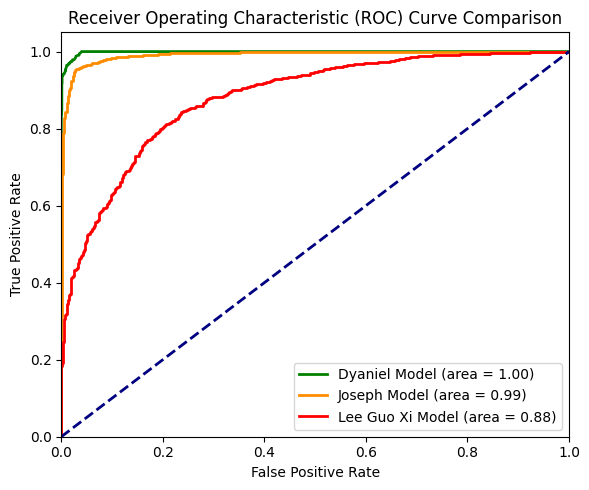

In [101]:
# Combined ROC Curve
plt.figure(figsize=(6, 5))

# Dyaniel Model ROC Curve
if hasattr(bias_corrector, "predict_proba"):
    dy_y_scores = bias_corrector.predict_proba(dy2_X_test)[:, 1]
    dy_roc_auc = roc_auc_score(dy2_y_test, dy_y_scores)
    fpr_dy, tpr_dy, thresholds_dy = roc_curve(dy2_y_test, dy_y_scores)
    plt.plot(fpr_dy, tpr_dy, color='green', lw=2, label=f'Dyaniel Model (area = {dy_roc_auc:.2f})')
else:
    print("ROC curve for Dyaniel Model cannot be plotted as the model does not have 'predict_proba'.")

# Joseph Model ROC Curve
js_y_scores = svm_model.decision_function(js2_X_test)
js_roc_auc = roc_auc_score(js2_y_test, js_y_scores)
fpr_js, tpr_js, thresholds_js = roc_curve(js2_y_test, js_y_scores)
plt.plot(fpr_js, tpr_js, color='darkorange', lw=2, label=f'Joseph Model (area = {js_roc_auc:.2f})')

# Lee Guo Xi Model ROC Curve (LSTM)
guoxi_roc_auc = roc_auc_score(guoxi_y_test, y_proba) # Use y_proba for ROC-AUC
fpr_guoxi, tpr_guoxi, thresholds_guoxi = roc_curve(guoxi_y_test, y_proba)
plt.plot(fpr_guoxi, tpr_guoxi, color='red', lw=2, label=f'Lee Guo Xi Model (area = {guoxi_roc_auc:.2f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Metrics Comparison

In [99]:
# Create a dictionary to store the metrics
metrics_data = {
    'Model': ['Dyaniel Model', 'Joseph Model', 'Lee Guo Xi Model'], # Added Lee Guo Xi Model
    'Accuracy': [dy_accuracy, js_accuracy, guoxi_accuracy], # Added guoxi_accuracy
    'Precision': [precision, js_precision, guoxi_precision], # Added guoxi_precision
    'Recall': [recall, js_recall, guoxi_rec], # Added guoxi_rec (recall for guoxi model)
    'F1-Score': [dy_f1, js_f1, guoxi_f1], # Added guoxi_f1
    'Training Time (min)': [dy_training_time, js_training_time, guoxi_training_time], # Added guoxi_training_time and converted to minutes
    'Prediction Time (ms)': [dy_prediction_time, js_prediction_time, guoxi_prediction_time] # Added guoxi_prediction_time
}

# Create a pandas DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics_data)

# Display the DataFrame
display(metrics_df)

,Model,Accuracy,Precision,Recall,F1-Score,Training Time (min),Prediction Time (ms)
0,Dyaniel Model,0.986002,0.986091,0.986002,0.985830,3.5358,33.9909
1,Joseph Model,0.959318,0.961336,0.957130,0.959228,4.6008,1.6370
2,Lee Guo Xi Model,0.800525,0.793526,0.793526,0.799119,0.0767,0.7821


# Extracting Weights for Keras Models (RNN, CNN, LSTM)

In [61]:
# Extract Dyaniel RNN Model
RNN_model.save_weights('rnn_weights.weights.h5')
print("RNN model weights saved to 'rnn_weights.weights.h5'")

# Extract Joseph CNN Model
CNN_model.save_weights('cnn_weights.weights.h5')
print("CNN model weights saved to 'cnn_weights.weights.h5'")

# Extract GuoXi LSTM Model
model.save_weights('lstm_weights.weights.h5')
print("LSTM model weights saved to 'lstm_weights.weights.h5'")

RNN model weights saved to 'rnn_weights.weights.h5'
CNN model weights saved to 'cnn_weights.weights.h5'
LSTM model weights saved to 'lstm_weights.weights.h5'
